In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1]:
import numpy as np
import tensorflow as tf
import re
import pandas as pd
import spacy
import gc
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack as sparse_vstack
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense,Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.callbacks import TensorBoard

# **FASE 1**

In [2]:
# Step 1: Load data
train_df = pd.read_csv('train.csv', encoding='latin1')
test_df = pd.read_csv('test.csv', encoding='latin1')

def limpiar_texto(texto):
    texto = re.sub(r'[^\w\s]', '', str(texto)).lower()
    return texto

In [3]:
# # Step 2: Prepare data
# train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
# test_df['text_clean'] = test_df['text'].apply(limpiar_texto)
# corpus = pd.concat([train_df['text_clean'], test_df['text_clean']]).tolist()

# #cuando aumentemos a todo el corpus poner estas 2 líenas solo para dataset compelto y elimianr lo de small_corpus
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(corpus)

# # Identificar las 10 palabras más utilizadas con significado (susantivos) cargando el modelo de spaCy en inglés
# try:
#     nlp = spacy.load("en_core_web_sm")
# except OSError:
#     import os
#     os.system("python -m spacy download en_core_web_sm")
#     nlp = spacy.load("en_core_web_sm")

# # Crear el set de stopwords incluyendo 'nan'
# stop_words = set(nlp.Defaults.stop_words)
# stop_words.add('nan')

# # Función para filtrar solo nombres con significado
# def es_nombre_con_significado(palabra):
#     if len(palabra) < 2 or palabra in stop_words:
#         return False
#     doc = nlp(palabra)
#     # Solo acepta si la palabra es un sustantivo (NOUN o PROPN)
#     return any(token.pos_ in {"NOUN", "PROPN"} for token in doc)

# # Aplicar filtro al vocabulario real
# palabras_filtradas = {
#     word: count for word, count in tokenizer.word_counts.items()
#     if es_nombre_con_significado(word)
# }

# # Ordenar y seleccionar top 10
# top_10 = sorted(palabras_filtradas.items(), key=lambda x: x[1], reverse=True)[:10]

# # Mostrar resultados
# print("\nTop 10 nombres con significado:")
# print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
# for idx, (palabra, freq) in enumerate(top_10, 1):
#     print(f"{idx:2}. {palabra:<15} → {freq:>6} apariciones")


# # Convertir textos a secuencias de enteros
# train_sequences = tokenizer.texts_to_sequences(train_df['text_clean'])
# test_sequences = tokenizer.texts_to_sequences(test_df['text_clean'])
# all_sequences = train_sequences + test_sequences

# # Diccionarios de palabras a índices y viceversa
# word2idx = tokenizer.word_index
# idx2word = {i: w for w, i in word2idx.items()}
# vocab_size = len(word2idx) + 1



# --- Step 2: Prepare data (10% train + 10% test) ---

# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)

# 2) Muestreo 50% de cada uno
small_train_df = train_df.sample(frac=0.5, random_state=42)
small_test_df  = test_df.sample(frac=0.1, random_state=42)

train_corpus_small = small_train_df['text_clean'].tolist()
test_corpus_small  = small_test_df ['text_clean'].tolist()
small_corpus       = train_corpus_small + test_corpus_small

print(f"Frases usadas → train: {len(train_corpus_small)}, test: {len(test_corpus_small)}")

# 3) Tokenizer limitado a 1000 palabras + OOV
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(small_corpus)
vocab_size = 1000 + 1

# Diccionarios para después
word2idx = tokenizer.word_index
idx2word = {i:w for w,i in word2idx.items()}

# 4) Top-10 nombres con spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

stop_words = set(nlp.Defaults.stop_words) | {'nan'}


Frases usadas → train: 13740, test: 482


In [4]:
train_df.head(1)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,id have responded if i were going


# **FASE 2**

In [5]:
def es_nombre(palabra):
    if len(palabra)<2 or palabra in stop_words: return False
    return any(t.pos_ in {"NOUN","PROPN"} for t in nlp(palabra))

filtradas = {w:c for w,c in tokenizer.word_counts.items() if es_nombre(w)}
top_10 = sorted(filtradas.items(), key=lambda x:x[1], reverse=True)[:10]
print("Top 10 nombres con significado:")
for i,(w,f) in enumerate(top_10,1):
    print(f"{i}. {w:<15} → {f} apariciones")

# 5) Secuencias sólo del 10%
train_sequences_small = tokenizer.texts_to_sequences(train_corpus_small)
test_sequences_small  = tokenizer.texts_to_sequences(test_corpus_small)
all_sequences        = train_sequences_small + test_sequences_small

Top 10 nombres con significado:
1. day             → 1037 apariciones
2. today           → 572 apariciones
3. love            → 559 apariciones
4. lol             → 508 apariciones
5. time            → 484 apariciones
6. mothers         → 379 apariciones
7. night           → 368 apariciones
8. thanks          → 329 apariciones
9. home            → 328 apariciones
10. hope            → 292 apariciones


In [ ]:
# # Step 3: Generación de pares con ventanas 2 y 4
# pairs_dict = {'window_2': [], 'window_4': []}

# for seq in all_sequences:
#     # Ventana 2
#     sg_pairs_2, _ = skipgrams(seq, vocab_size, window_size=2, negative_samples=0)
#     pairs_dict['window_2'].extend(sg_pairs_2)

#     # Ventana 4
#     sg_pairs_4, _ = skipgrams(seq, vocab_size, window_size=4, negative_samples=0)
#     pairs_dict['window_4'].extend(sg_pairs_4)

In [6]:
# Step 3: Generación de pares con ventanas 2 y 4
pairs_dict = {'window_2': []}

for seq in all_sequences:
    # Ventana 2
    sg_pairs_2, _ = skipgrams(seq, vocab_size, window_size=2, negative_samples=0)
    pairs_dict['window_2'].extend(sg_pairs_2)

In [7]:
# Step 4: One-hot encoding optimizado
def sparse_onehot(batch, vocab_size):
    rows = np.arange(len(batch))
    cols = np.array(batch).flatten()
    data = np.ones_like(cols, dtype=np.float32)
    return csr_matrix((data, (rows, cols)), shape=(len(batch), vocab_size), dtype=np.float32)

In [16]:
from tensorflow.keras.optimizers import Adam
# Hiperparámetros y estructuras
embedding_sizes  = [45]               # podés poner [45, 312, 752]
window_sizes     = ['window_2']       # luego agregás 'window_4'
loss_histories   = {}
final_embeddings = {}
models           = {}

for emb_size in embedding_sizes:
    for window in window_sizes:
        current_pairs = pairs_dict[window]
        if not current_pairs:
            continue

        # Usamos skipgrams con muestreo negativo
        targets, contexts = zip(*current_pairs)
        targets  = np.array(targets,  dtype='int32')
        contexts = np.array(contexts, dtype='int32')

        # Etiquetas para pares (1 positivos, 0 negativos)
        # Si usaste negative_samples en skipgrams, tendrás algo como:
        # sg_pairs, labels = skipgrams(seq, ..., negative_samples=1.0)
        y_train = np.ones(len(targets), dtype=np.float32)

        # ENTRADAS como índices, no one-hot
        target_input = Input(shape=(), dtype='int32', name='target_input')
        context_input= Input(shape=(), dtype='int32', name='context_input')

        # Capa de embeddings compartida
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=emb_size,
            name=f"embedding_{emb_size}_{window}"
        )

        # Vectores de palabras
        target_vector  = embedding_layer(target_input)
        context_vector = embedding_layer(context_input)

        # Producto punto
        dot_product = Dot(axes=-1)([target_vector, context_vector])
        dot_product = Reshape((1,))(dot_product)

        # Clasificador binario
        output = Dense(1, activation='sigmoid')(dot_product)

        # Construir modelo
        model = Model(inputs=[target_input, context_input], outputs=output)
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.01),  # más rápido, podés ajustar
            metrics=['accuracy']
        )

        # Guardar y entrenar
        key = f'emb_{emb_size}_{window}'
        models[key] = model
        history = model.fit(
            [targets, contexts],
            y_train,
            epochs=2,
            batch_size=264,
            verbose=1
        )

        loss_histories[key]   = history.history['loss']
        final_embeddings[key] = embedding_layer.get_weights()[0]

Epoch 1/2
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9941 - loss: 0.1544
Epoch 2/2
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 1.0000 - loss: 0.0028


In [21]:
# Recorre cada modelo en el diccionario y muestra su summary
for key, mdl in models.items():
    print(f"\n=== Summary de {key} ===")
    mdl.summary()



=== Summary de emb_45_window_2 ===


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │     45,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1)         │          0 │ dot_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          2 │ reshape_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 135,143 (527.91 KB)

 Trainable params: 45,047 (175.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,096 (351.94 KB)

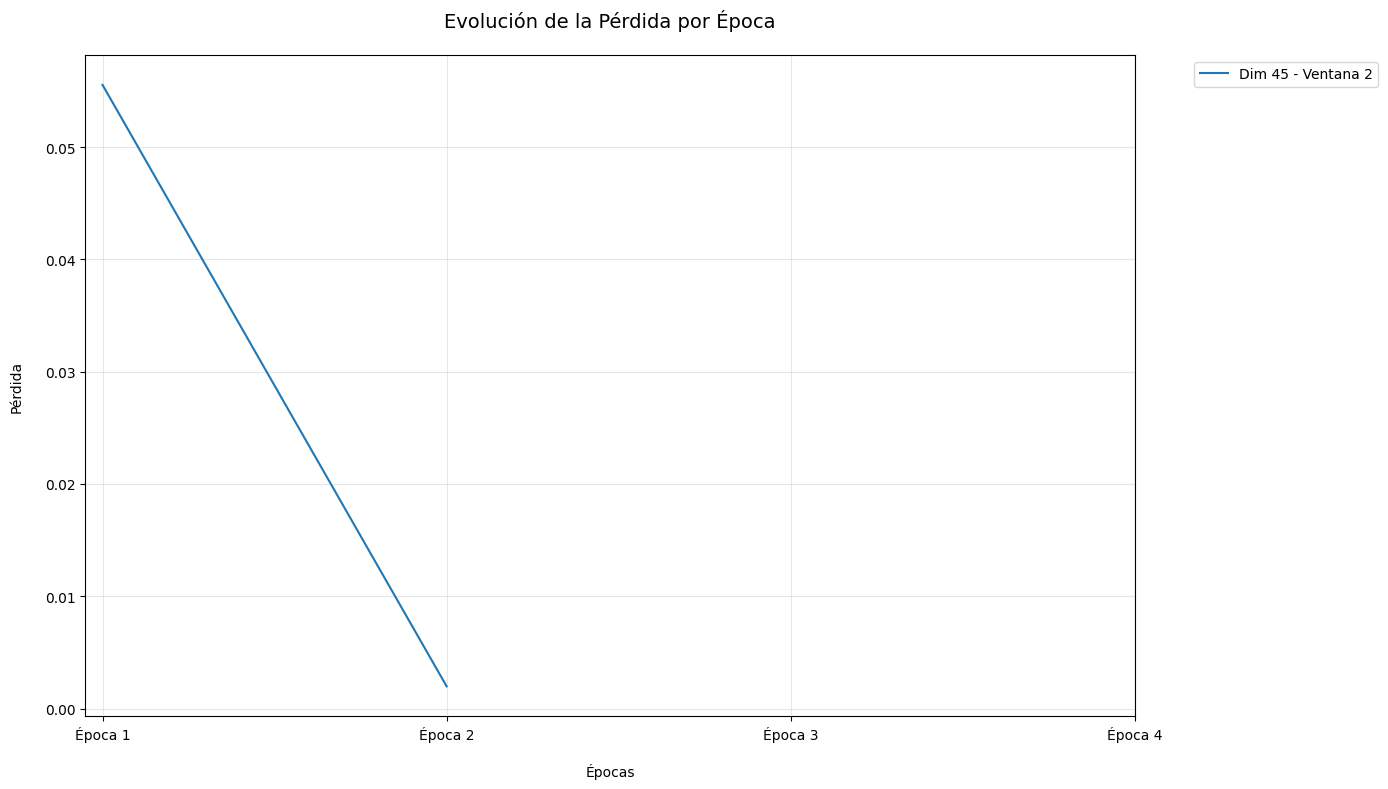

In [22]:
# Step 6: Visualización de la pérdida
plt.figure(figsize=(14, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, emb_size in enumerate(embedding_sizes):
    for window in window_sizes:
        key = f'emb_{emb_size}_{window}'
        if key in loss_histories:
            plt.plot(
                loss_histories[key],
                linestyle='--' if 'window_4' in key else '-',
                color=colors[idx],
                label=f'Dim {emb_size} - Ventana {window.split("_")[1]}'
            )

plt.title('Evolución de la Pérdida por Época', pad=20, fontsize=14)
plt.xlabel('Épocas', labelpad=15)
plt.ylabel('Pérdida', labelpad=15)
plt.xticks(range(4), [f'Época {i+1}' for i in range(4)])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_evolution.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
# Example: vector for "love"
idx = word2idx["love"]

print(f"Embedding for 'love':\n{final_embeddings['emb_45_window_2'][idx]}")

Embedding for 'love':
[ 0.20378137 -0.03701727  0.2646498  -0.11921605 -0.01387983 -0.12920122
  0.24241029 -0.24454923  0.1932945  -0.25294214  0.00562884 -0.13171194
  0.070041   -0.18130316  0.01940314  0.1874355  -0.33415374  0.11762774
  0.0242296   0.04062894 -0.14142087  0.21937238  0.29690737  0.01812905
  0.18730804  0.12801585  0.06881994 -0.113443   -0.24448338 -0.24595442
 -0.04407727  0.16888323  0.17971586 -0.25756457  0.10830981  0.2138978
  0.10815945  0.11341472  0.18375254  0.02760234 -0.08112929 -0.09571756
 -0.14525513 -0.20782368  0.18367238]


In [24]:


# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w,_ in top_10]

# 2) Extrae los índices solo de las que realmente estén en tu vocabulario
indices = []
words   = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Recorre cada modelo en final_embeddings
for model_key, emb_matrix in final_embeddings.items():
    # 4) Submatriz de solo las top palabras
    submat = emb_matrix[indices]            # (n_words, emb_dim)

    # 5) Calcula similitud de coseno
    sim_mat = cosine_similarity(submat)     # (n_words, n_words)

    # 6) Construye DataFrame y muestra
    print(f"\n— Similitud de coseno para {model_key} —")
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)
    display(df_sim)




— Similitud de coseno para emb_45_window_2 —


,day,today,love,lol,time,mothers,night,thanks,home,hope
day,1.000000,-0.139777,0.001921,-0.143926,0.427297,-0.455604,0.349796,0.175026,-0.024365,-0.116173
today,-0.139777,1.000000,0.011209,0.111983,-0.157814,0.057064,-0.196571,0.045991,-0.157141,-0.039890
love,0.001921,0.011209,1.000000,-0.120331,-0.039600,0.129690,-0.044688,-0.076843,-0.191038,0.355727
lol,-0.143926,0.111983,-0.120331,1.000000,-0.016830,-0.082389,-0.144034,-0.285823,-0.088475,0.075232
time,0.427297,-0.157814,-0.039600,-0.016830,1.000000,-0.053916,0.429439,0.431082,-0.111606,0.089472
mothers,-0.455604,0.057064,0.129690,-0.082389,-0.053916,1.000000,-0.274238,-0.025837,-0.083975,-0.150571
night,0.349796,-0.196571,-0.044688,-0.144034,0.429439,-0.274238,1.000000,0.190761,0.027027,0.092599
thanks,0.175026,0.045991,-0.076843,-0.285823,0.431082,-0.025837,0.190761,1.000000,0.068775,0.235041
home,-0.024365,-0.157141,-0.191038,-0.088475,-0.111606,-0.083975,0.027027,0.068775,1.000000,-0.145249
hope,-0.116173,-0.039890,0.355727,0.075232,0.089472,-0.150571,0.092599,0.235041,-0.145249,1.000000


In [25]:


# Define aquí tres grupos basados en tu top-10
grupos = {
    'Día/Mañana':     ['day', 'today', 'morning'],
    'Emoción Positiva':['love', 'hope', 'thanks'],
    'Risa/Conversación':['lol', 'thanks', 'mothers']  # ejemplo mixto
}

for model_key, emb_matrix in final_embeddings.items():
    print(f"\n=== Similitudes para {model_key} ===")
    # Extrae solo los vectores de tus 10 palabras
    submat = emb_matrix[indices]           # (10, emb_dim)
    sim_mat = cosine_similarity(submat)    # (10, 10)

    # Mapea palabra -> posición en 'words'
    pos = {w:i for i,w in enumerate(words)}

    for nombre, group in grupos.items():
        # Filtra solo los que realmente están en tu top
        valid = [w for w in group if w in pos]
        idxs  = [pos[w] for w in valid]
        if len(idxs) < 2:
            print(f"  * Grupo «{nombre}» tiene <2 palabras válidas, omito.")
            continue

        sims = []
        print(f"\n  Grupo «{nombre}»: {valid}")
        for i,j in combinations(idxs, 2):
            s = sim_mat[i, j]
            sims.append(s)
            print(f"    Sim({words[i]}, {words[j]}) = {s:.3f}")

        print(f"    → Similitud media = {np.mean(sims):.3f}")




=== Similitudes para emb_45_window_2 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = -0.140
    → Similitud media = -0.140

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.356
    Sim(love, thanks) = -0.077
    Sim(hope, thanks) = 0.235
    → Similitud media = 0.171

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = -0.286
    Sim(lol, mothers) = -0.082
    Sim(thanks, mothers) = -0.026
    → Similitud media = -0.131


# **FASE 3**

<Axes: >

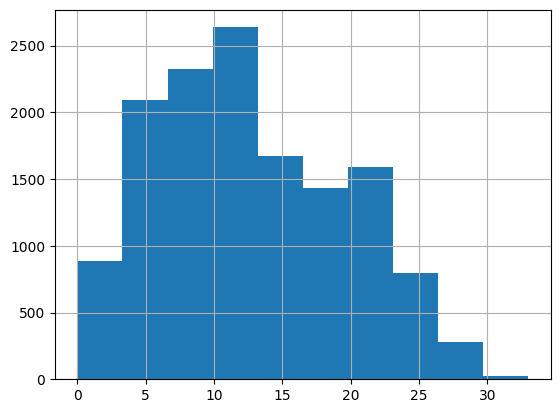

In [28]:
import matplotlib.pyplot as plt
small_train_df['text_clean'].str.split().map(len).hist()

In [39]:
# --- FASE 3: DOS RNN SECUENCIALES CON EMBEDDINGS PRE-ENTRENADOS ---

# Parámetros generales
maxlen        = 30
batch_rnn     = 32
epochs_rnn    = 5
learning_rate = 0.004

# 1) Usa SMALL_TRAIN_DF / SMALL_TEST_DF y quita filas sin etiqueta
small_train_df.dropna(subset=['sentiment'], inplace=True)
small_test_df.dropna(subset=['sentiment'], inplace=True)

texts_train = small_train_df['text_clean'].tolist()
texts_test  = small_test_df['text_clean'].tolist()

# 2) LabelEncoder para convertir strings → enteros
le       = LabelEncoder()
y_train  = le.fit_transform(small_train_df['sentiment'])
y_test   = le.transform(small_test_df['sentiment'])
y_train  = y_train.astype('int32')
y_test   = y_test.astype('int32')
num_classes = len(le.classes_)
print("Clases sentiment codificadas:", le.classes_)

# 3) Secuencias + padding
seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test  = tokenizer.texts_to_sequences(texts_test)
X_train   = pad_sequences(seq_train, maxlen=maxlen, padding='post')
X_test    = pad_sequences(seq_test,  maxlen=maxlen, padding='post')

# 4) Crea datasets optimizados
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                         .shuffle(len(X_train)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)

# 5) Elige qué embeddings usar
key_A = 'emb_45_window_2'
key_B = 'emb_45_window_2'  # <-- ¡elige uno distinto al anterior!
emb_A = final_embeddings[key_A]
emb_B = final_embeddings[key_B]
vocab_sz = vocab_size

# 6) Modelo A: Bi-LSTM + Bi-GRU (profundo)
model_A = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_A.shape[1],
              weights=[emb_A],
              mask_zero=True,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
], name='Model_A')
model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
print("\n--- Model A Summary ---")
model_A.summary()

# 7) Modelo B: Bi-LSTM simple (profundo)
model_B = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_B.shape[1],
              weights=[emb_B],
              mask_zero=True,
              trainable=False),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
], name='Model_B')
model_B.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
print("\n--- Model B Summary ---")
model_B.summary()


Clases sentiment codificadas: ['negative' 'neutral' 'positive']

--- Model A Summary ---


Model: "Model_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │        45,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,045 (175.96 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 45,045 (175.96 KB)


--- Model B Summary ---


Model: "Model_B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │        45,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,045 (175.96 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 45,045 (175.96 KB)

In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # monitor validation loss
    factor=0.5,             # reduce by half
    patience=1,             # after 1 epoch with no improvement
    min_lr=1e-5,            # don't go below this
    verbose=1
)

In [41]:
# 8) Entrena ambos
print("\n>>> Entrenando Model A")
history_A = model_A.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[reduce_lr]
)

print("\n>>> Entrenando Model B")
history_B = model_B.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[reduce_lr]
)




>>> Entrenando Model A
Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 55s 98ms/step - accuracy: 0.4509 - loss: 1.0443 - val_accuracy: 0.5444 - val_loss: 0.9084 - learning_rate: 0.0040
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - accuracy: 0.6084 - loss: 0.8659 - val_accuracy: 0.6083 - val_loss: 0.8171 - learning_rate: 0.0040
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.6594 - loss: 0.7757 - val_accuracy: 0.6417 - val_loss: 0.8067 - learning_rate: 0.0040
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.6937 - loss: 0.7101 - val_accuracy: 0.6444 - val_loss: 0.7959 - learning_rate: 0.0040
Epoch 5/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.7189 - loss: 0.6488 - val_accuracy: 0.6500 - val_loss: 0.7733 - learning_rate: 0.0040

>>> Entrenando Model B
Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.4560 - loss: 1.0464 - val_accuracy: 0.5389 - val_loss: 0.9423 - learning_rate: 0.0040
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━

In [43]:
import numpy as np

# Get predicted class probabilities
y_probs = model_A.predict(X_test)  # or model_B

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


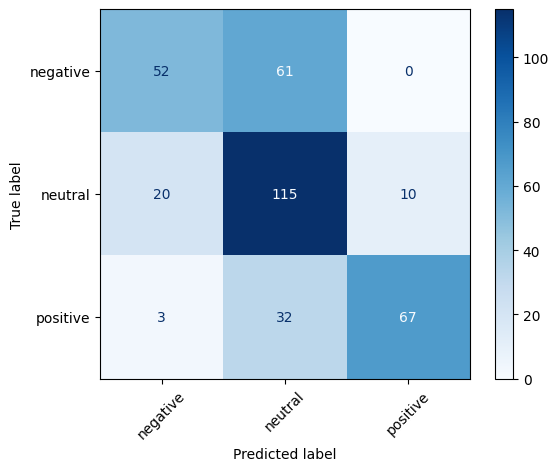

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


In [45]:
import numpy as np

# Get predicted class probabilities
y_probs = model_B.predict(X_test)  # or model_B

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


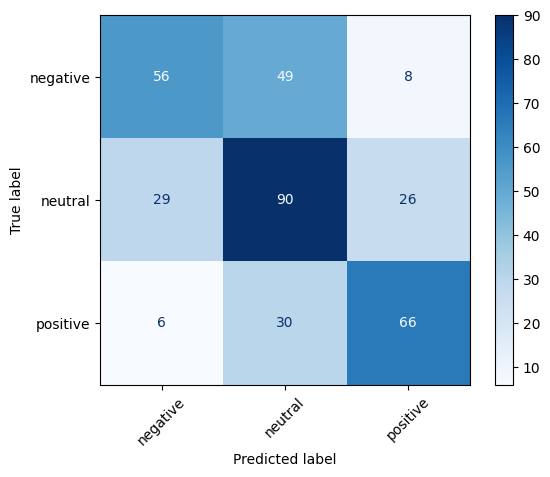

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


=== Evaluación en TEST ===

--- Model A ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.46      0.55       113
     neutral       0.55      0.79      0.65       145
    positive       0.87      0.66      0.75       102

    accuracy                           0.65       360
   macro avg       0.71      0.64      0.65       360
weighted avg       0.69      0.65      0.65       360


--- Model B ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.50      0.55       113
     neutral       0.53      0.62      0.57       145
    positive       0.66      0.65      0.65       102

    accuracy                           0.59       360
   macro avg       0.60      0.59      0.59       360
weighted avg       0.59      0.59      0.59       360



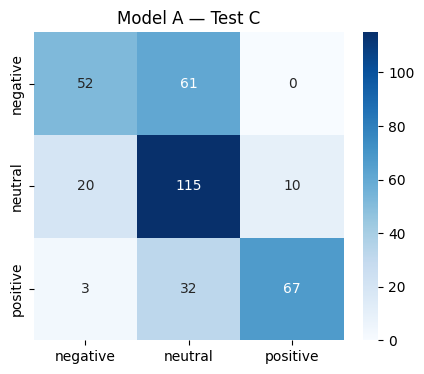

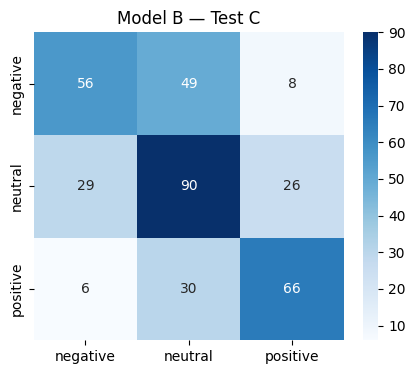

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n=== Evaluación en TEST ===")
for name, model in [('Model A', model_A), ('Model B', model_B)]:
    print(f"\n--- {name} ---")

    # Predicción en test
    y_test_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_probs, axis=1)

    # Matriz de confusión
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Métricas detalladas
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Gráfico
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} — Test C')


In [62]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1) Saca una frase de small_test_df (por ejemplo la primera)
sample_text = small_test_df['text_clean'].iloc[2]
print("Sample text:", sample_text)

# 2) Convierte a secuencia y pad
seq = tokenizer.texts_to_sequences([sample_text])
seq_pad = pad_sequences(seq, maxlen=maxlen, padding='post')

# 3) Predicción con Model A
prob_A = model_A.predict(seq_pad)[0,0]
pred_A = int(prob_A > 0.5)
print(f"\nModel A prediction → prob_positive = {prob_A:.3f}, class = {pred_A}")

# 4) Predicción con Model B
prob_B = model_B.predict(seq_pad)[0,0]
pred_B = int(prob_B > 0.5)
print(f"Model B prediction → prob_positive = {prob_B:.3f}, class = {pred_B}")


Sample text:  im looking forward too see and hear you in norway live fast
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

Model A prediction → prob_positive = 0.150, class = 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Model B prediction → prob_positive = 0.153, class = 0


In [72]:
# List of sample indices to test
sample_indices = [40, 101, 98]

# Loop through each sample
for idx in sample_indices:
    # 1) Saca una frase de prueba
    sample_text = small_test_df['text_clean'].iloc[idx]
    print(f"\nSample text: {sample_text}")

    # 2) Tokeniza y paddea la frase
    sample_seq = tokenizer.texts_to_sequences([sample_text])
    sample_pad = pad_sequences(sample_seq, maxlen=maxlen, padding='post')

    # 3) MODELO A
    print("=================Utilizando el modelo A=================")
    model = model_A  # o model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")

    # MODELO B
    print("=================Utilizando el modelo B=================")
    model = model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")



Sample text: at    happy mothers dayyy deniseee 3
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

Predicted sentiment: positive with
Probability of negative: 0.00699281
Probability of neutral: 0.04744217
Probability of positive: 0.94556499
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Predicted sentiment: positive with
Probability of negative: 0.00147588
Probability of neutral: 0.01058698
Probability of positive: 0.98793715

Sample text: ive not had a reply on my topic yet  lolz welll its not somethin you could reply too but yanno 
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

Predicted sentiment: neutral with
Probability of negative: 0.27349475
Probability of neutral: 0.63771528
Probability of positive: 0.08878997
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Predicted sentiment: neutral